In [1]:
# Import libraries and dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import os

from torchvision.io import read_image
from PIL import Image, ImageColor
import matplotlib.colors as mcolors
from script_util import create_model_diffusion

from SDE_datareduction import get_test_data, get_data
from main import IMAGE_DATASET_PATH, STRUCTURE_DATASET_PATH, BASE_OUTPUT

from SDE_utils import *
from SDE_test import mae, count_parameters, error_image

Script Dir C:\Users\tabor\Documents\Programming\MachineLearning\MachineLearningModels\SDE_conditioned


Create a model and print its parameters according to config

In [2]:
# Create a model and print its parameters
with open('config.json', "r", encoding="utf-8") as f:
    config = json.load(f)
    
model, *_ = create_model_diffusion('cpu', **config)

parameters = count_parameters(model)

print(f"Parameters: {parameters}")

Parameters: 431156742


Create a Comparison Plot from the results excel MAE vs Train Split

In [37]:
# --- Configuration ---
# IMPORTANT: Replace this with the actual path to your Excel file
file_path = r"C:\Users\tabor\Documents\Studie\Bachelor\Jaar 4\BEP\Results\Results_journal_comparison.xlsx"
sheet_name = "128 Pix"
output_filename = 'unet_mae_distribution_plot.eps' # Name for the saved plot image

# --- Load Data ---
try:
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    print(f"Successfully loaded data from '{file_path}', sheet '{sheet_name}'.")
except FileNotFoundError:
    print(f"Error: File not found at '{file_path}'. Please check the path.")
    # Exit the script if the file isn't found
    exit()
except Exception as e:
    print(f"An error occurred while reading the Excel file: {e}")
    exit()

Successfully loaded data from 'C:\Users\tabor\Documents\Studie\Bachelor\Jaar 4\BEP\Results\Results_journal_comparison.xlsx', sheet '128 Pix'.


In [38]:
# --- Data Cleaning and Preparation ---
# Remove rows where 'Job ID' is missing (adjust column name if different)
if 'Job ID' in df.columns:
    df = df.dropna(subset=['Job ID'])
else:
    print("Warning: 'Job ID' column not found. Skipping dropna based on it.")

# Check if required columns exist
required_columns = ['Model', 'Train Split', 'MAE']
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    print(f"Error: Missing required columns: {', '.join(missing_cols)}. Cannot proceed.")
    exit()
    
df['Train Split'] = df['Train Split'].round(1)

print(df['Train Split'].unique())
    
train_splits = [0.8, 0.6, 0.4, 0.2]

filtered_df = df[df['Train Split'].isin(train_splits)].copy()

filtered_df['Train Split'] = filtered_df['Train Split']*100
filtered_df['MAE'] = filtered_df['MAE']*100

filtered_df

[0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1]


,Job ID,Model,Blocks,Heads,Parameters,Dataset,Learn Sigma,Attention Split,Test Split,Validation Split,...,Learning Rate,Noise Steps,SSIM,PSNR,MAE,Max MAE,Max Error,BM SSIM,BM MAE,BM Epoch
0,8907.0,Geo2Field-169M,2.0,4.0,168902470.0,5000.0,1.0,0.0,0.1,0.1,...,0.00002,250.0,0.993500,40.408000,0.980000,0.028992,0.235300,0.993500,0.007700,994.0
1,2389.0,Geo2Field-169M,2.0,4.0,168902470.0,5000.0,1.0,0.0,0.1,0.1,...,0.00002,250.0,0.994120,38.861241,1.271321,0.035366,0.254902,0.994798,0.009197,979.0
2,9707.0,Geo2Field-169M,2.0,4.0,168902470.0,5000.0,1.0,0.0,0.1,0.1,...,0.00002,250.0,0.987636,36.184213,1.875778,0.037918,0.258824,0.994638,0.009445,979.0
3,7978.0,Geo2Field-169M,2.0,4.0,168902470.0,5000.0,1.0,0.0,0.1,0.1,...,0.00002,250.0,0.994413,39.612723,1.080028,0.040280,0.254902,0.994594,0.009246,979.0
4,3350.0,Geo2Field-169M,2.0,4.0,168902470.0,5000.0,1.0,0.0,0.1,0.1,...,0.00002,250.0,0.988297,37.328907,1.601648,0.037731,0.258824,0.994606,0.009230,979.0
5,4045.0,Geo2Field-169M,2.0,4.0,168902470.0,5000.0,1.0,0.0,0.1,0.1,...,0.00002,250.0,0.993624,40.214868,0.984208,0.036397,0.301961,0.994561,0.009969,899.0
6,6252.0,Geo2Field-169M,2.0,4.0,168902470.0,5000.0,1.0,0.0,0.1,0.1,...,0.00002,250.0,0.993049,40.241331,0.998464,0.039838,0.337255,0.994450,0.009823,969.0
13,3642.0,Geo2Field-169M,2.0,4.0,168902470.0,5000.0,1.0,0.0,0.3,0.1,...,0.00002,250.0,0.993500,39.444000,1.130000,0.042304,0.294100,0.994700,0.010100,979.0
14,7865.0,Geo2Field-169M,2.0,4.0,168902470.0,5000.0,1.0,0.0,0.3,0.1,...,0.00002,250.0,0.992900,39.036000,1.230000,0.043044,0.302000,0.994400,0.009900,994.0
15,6246.0,Geo2Field-169M,2.0,4.0,168902470.0,5000.0,1.0,0.0,0.3,0.1,...,0.00002,250.0,0.993800,39.071000,1.180000,0.038624,0.333300,0.994300,0.009860,959.0


03:15:39 - WARNING: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Generating plot...
Plot saved successfully as 'unet_mae_distribution_plot.eps'.


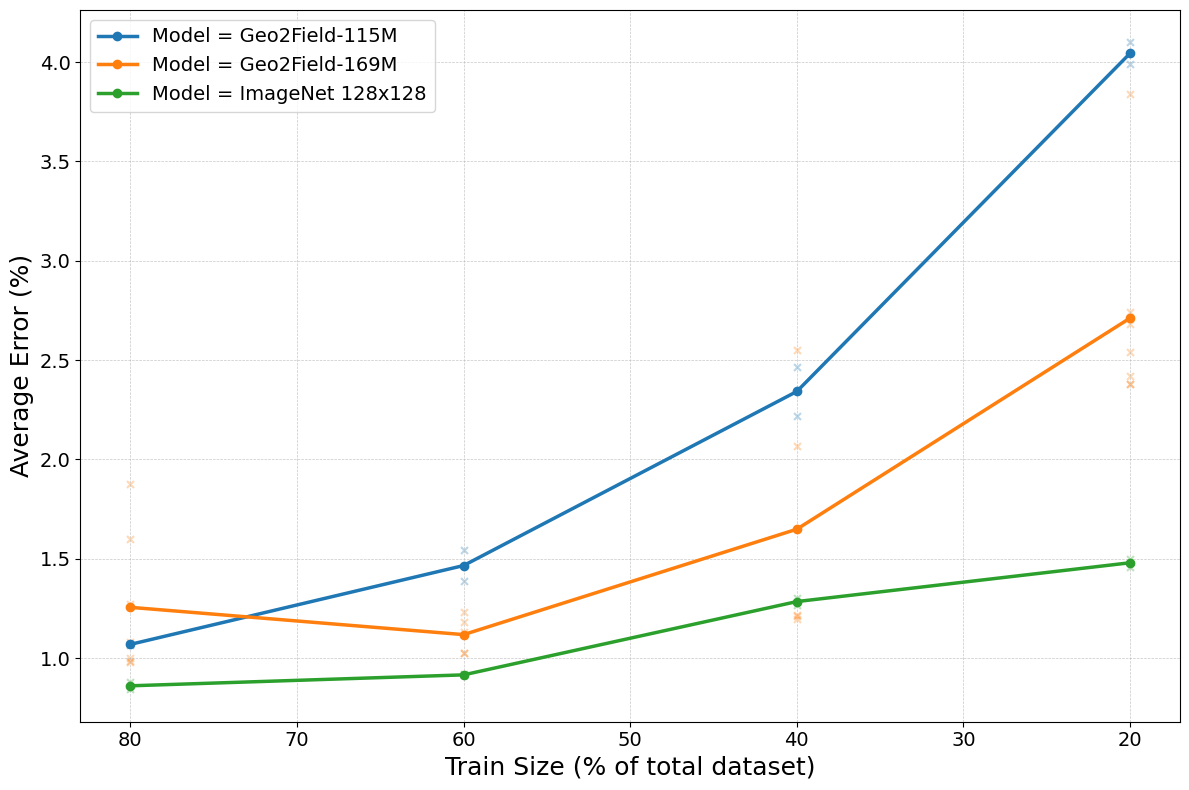

In [45]:
# --- Plotting ---
print("Generating plot...")

# Create a figure and a single axes object
fig, ax = plt.subplots(figsize=(12, 8)) # Single plot

# Get unique attention splits and assign colors
unique_models = sorted(filtered_df['Model'].unique())

# --- Plot data for each Attention Split group ---
for model in unique_models:
    group = filtered_df[filtered_df['Model'] == model]
    label = f"Model = {model}"
    # 1. Plot all individual MAE points as scatter plot
    ax.scatter(
        group['Train Split'],
        group['MAE'],
        marker='x',
        alpha=0.3,  # Transparency to show density
        s=25,       # Marker size
        label='_nolegend_' # Hide scatter points from the legend
    )

    # 2. Calculate and plot the average MAE line
    average_mae = group.groupby('Train Split')['MAE'].mean().reset_index()
    # Sort by 'Train Split' in descending order for plotting with inverted axis
    average_mae = average_mae.sort_values('Train Split', ascending=False)

    ax.plot(
        average_mae['Train Split'],
        average_mae['MAE'],
        marker='o',        # Marker style
        linestyle='-',     # Line style
        linewidth=2.5,     # Line thickness
        markersize=6,      # Marker size for average points
        label=label        # Label for the legend (only for the average line)
    )

# --- Customize Plot ---
ax.set_xlabel('Train Size (% of total dataset)', fontsize=18)
ax.set_ylabel('Average Error (%)', fontsize=18)

# Invert the x-axis (Train Size)
ax.invert_xaxis()

# Add grid lines for better readability
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Add legend for the average lines
ax.legend(fontsize=14)

ax.tick_params(axis='both',      # Apply to both x and y axes
               which='major',    # Affects major ticks
               labelsize=14)

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# --- Save and Show Plot ---
try:
    plt.savefig(output_filename)
    print(f"Plot saved successfully as '{output_filename}'.")
except Exception as e:
    print(f"Error saving plot: {e}")

# Display the plot
plt.show()

Sample Images using an Existing Model

In [13]:
# Load config and establish paths for testing an existing model
folder_path0 = r"C:\Users\tabor\Documents\Studie\Bachelor\Jaar 4\BEP\Results\Results_journal\results\SmallUNet_nblocks_2_noisesteps_250_smartsplit_False_9013"
folder_path1 = r"C:\Users\tabor\Documents\Studie\Bachelor\Jaar 4\BEP\Results\Results_journal\results\UNet_nblocks_2_noisesteps_250_smartsplit_False_8907"
folder_path2 = r"C:\Users\tabor\Documents\Studie\Bachelor\Jaar 4\BEP\Results\Results_journal\results\LargeUNet_nblocks_2_noisesteps_250_smartsplit_False_2120"

folder_paths = [folder_path0, folder_path1, folder_path2]

# folder_path0 = r"C:\Users\tabor\Documents\Studie\Bachelor\Jaar 4\BEP\Results\Results_journal\results\UNet_nblocks_2_noisesteps_250_smartsplit_False_9656"
# folder_paths = [folder_path0]

model_paths = []
configs = []
for folder_path in folder_paths:
    model_paths.append(os.path.join(folder_path, r"models\best_model.pth"))
    with open(os.path.join(folder_path, "config.json"), "r", encoding="utf-8") as f:
        config = json.load(f)
        configs.append(config)

In [14]:
# Get dataloaders, model and diffusiontools
# Get dataloaders with the first config file so that we can take the same sample for all models
config = configs[0]
train_dataloader, val_dataloader, test_dataloader, train_dataset, val_dataset, test_dataset = get_data(image_dataset_path=IMAGE_DATASET_PATH, structure_dataset_path=STRUCTURE_DATASET_PATH, **config)

Operating System: Windows. Number of DataLoader workers set to: 0
Loading dataset from: Images='C:\Users\tabor\Documents\Programming\MachineLearning\MachineLearningModels\data\figure_B_maxrange_5000\Output', Structures='C:\Users\tabor\Documents\Programming\MachineLearning\MachineLearningModels\data\figure_B_maxrange_5000\Structure'
Total dataset size: 5000 items.
Validation set size: 500
Using random split for train/test...
Train set size: 4000
Test set size: 500


In [4]:
# Get a batch and sample images with all models to test speed for each
input_images, label_images, *_ = next(iter(test_dataloader))
sample_count = 1 # Max value equal to value of batchsize

for model_path, config in zip(model_paths, configs):
    print(f"Sampling for model {model_path}")
    model, diffusion = create_model_diffusion('cuda', **config)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    samples = diffusion.p_sample_loop(model, sample_count, label_images)

Sampling for model C:\Users\tabor\Documents\Studie\Bachelor\Jaar 4\BEP\Results\Results_journal\results\UNet_nblocks_2_noisesteps_250_smartsplit_False_8907\models\best_model.pth


05:09:14 - INFO: Sampling 1 images
249it [00:06, 38.99it/s]


Sampling for model C:\Users\tabor\Documents\Studie\Bachelor\Jaar 4\BEP\Results\Results_journal\results\SmallUNet_nblocks_2_noisesteps_250_smartsplit_False_9013\models\best_model.pth


05:09:21 - INFO: Sampling 1 images
249it [00:04, 52.04it/s]


Sampling for model C:\Users\tabor\Documents\Studie\Bachelor\Jaar 4\BEP\Results\Results_journal\results\LargeUNet_nblocks_2_noisesteps_250_smartsplit_False_2120\models\best_model.pth


05:09:28 - INFO: Sampling 1 images
249it [00:16, 14.76it/s]


In [5]:
# Noise an image for a set amount of steps
target_image, label_image = test_dataset[11]
t = torch.tensor([50])
x_start = target_image.to('cuda')
print(x_start.shape)
noisy_image, *_ = diffusion.noise_images(x_start, t)

noisy_image = tensor_to_PIL(noisy_image)
target_image = tensor_to_PIL(target_image.unsqueeze(0))
label_image = tensor_to_PIL(label_image.unsqueeze(0))

print(target_image[0].size)
noisy_image[0].save(os.path.join("results", "noisy_image.png"))
target_image[0].save(os.path.join("results","target_image.png"))
label_image[0].save(os.path.join("results", "label_image.png"))


ValueError: too many values to unpack (expected 2)

In [15]:
# Get structure image from val dataset that we will use to sample results
baseline_image, label_image, *_ = val_dataset[100]

label_image_tens = label_image.unsqueeze(0)
baseline_image_tens = baseline_image.unsqueeze(0)

label_image_PIL = tensor_to_PIL(label_image_tens)[0]
baseline_image_PIL = tensor_to_PIL(baseline_image_tens)[0]

label_image_np = np.array(label_image_PIL)
baseline_image_np = np.array(baseline_image_PIL)

label_image_PIL.show()

In [16]:
# Sample an image for each model
sampled_images_tens = []
sampled_images_PIL = []

for model_path, config in zip(model_paths, configs):
    print(f"Sampling for model {model_path}")
    model, diffusion = create_model_diffusion('cuda', **config)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    sampled_image = diffusion.p_sample_loop(model, 1, label_image_tens)[0]
    sampled_images_tens.append(sampled_image)
    sampled_images_PIL.append(convert_grey_to_white(tensor_to_PIL(sampled_image)[0]))
    


Sampling for model C:\Users\tabor\Documents\Studie\Bachelor\Jaar 4\BEP\Results\Results_journal\results\SmallUNet_nblocks_2_noisesteps_250_smartsplit_False_9013\models\best_model.pth


10:11:40 - INFO: Sampling 1 images
249it [00:04, 50.71it/s]


Sampling for model C:\Users\tabor\Documents\Studie\Bachelor\Jaar 4\BEP\Results\Results_journal\results\UNet_nblocks_2_noisesteps_250_smartsplit_False_8907\models\best_model.pth


10:11:46 - INFO: Sampling 1 images
249it [00:06, 40.27it/s]


Sampling for model C:\Users\tabor\Documents\Studie\Bachelor\Jaar 4\BEP\Results\Results_journal\results\LargeUNet_nblocks_2_noisesteps_250_smartsplit_False_2120\models\best_model.pth


10:11:55 - INFO: Sampling 1 images
249it [00:17, 14.58it/s]


In [17]:
# Calculate error image from sampled images and baseline

error_images_PIL = []
for sample_image in sampled_images_PIL:
    error_image_PIL = error_image(structure=label_image_PIL, reference=baseline_image_PIL, sample=sample_image)
    error_images_PIL.append(error_image_PIL)
    
error_images_PIL[0].show()


In [18]:
## 1. Define Colormap and Normalization
max_error = 5
mae_values = np.linspace(0, max_error, 256)
colors = []
for mae in mae_values:
    hue = 120 - (mae / max_error) * 120
    color_rgb = ImageColor.getrgb(f"hsl({hue}, 100%, 50%)")
    color_normalized = tuple(c / 255 for c in color_rgb)
    colors.append(color_normalized)

cmap = mcolors.LinearSegmentedColormap.from_list('error_cmap', colors)
norm = mcolors.Normalize(vmin=0, vmax=max_error)
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

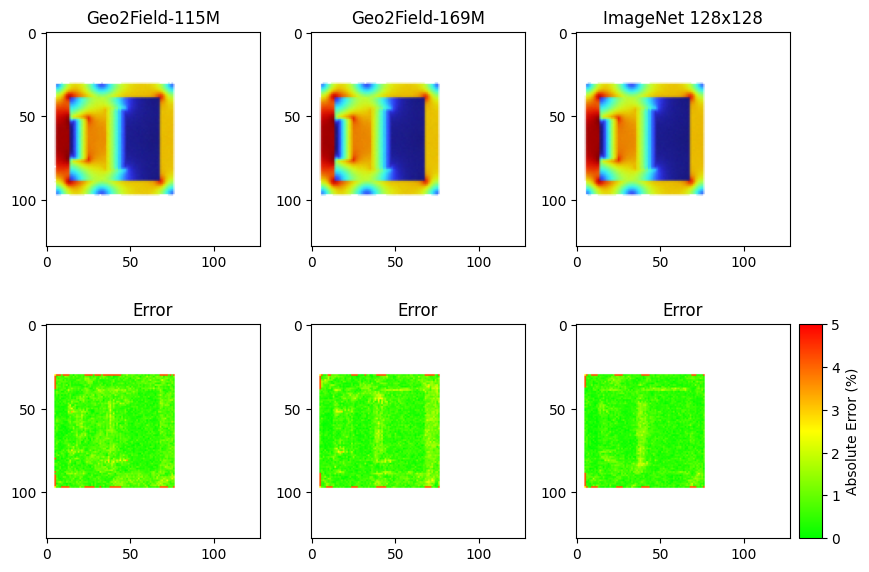

In [32]:
# Create plots
tick_locations = [0, 50, 100]
fig, axs = plt.subplots(2, 3, figsize=(9, 6))

axs[0,0].imshow(sampled_images_PIL[0])
axs[0,0].set_xticks(tick_locations)
axs[0,0].set_yticks(tick_locations)
axs[0,0].set_title('Geo2Field-115M')

axs[1,0].imshow(error_images_PIL[0])
axs[1,0].set_xticks(tick_locations)
axs[1,0].set_yticks(tick_locations)
axs[1,0].set_title('Error')

axs[0,1].imshow(sampled_images_PIL[1])
axs[0,1].set_xticks(tick_locations)
axs[0,1].set_yticks(tick_locations)
axs[0,1].set_title('Geo2Field-169M')

axs[1,1].imshow(error_images_PIL[1])
axs[1,1].set_xticks(tick_locations)
axs[1,1].set_yticks(tick_locations)
axs[1,1].set_title('Error')

axs[0,2].imshow(sampled_images_PIL[2])
axs[0,2].set_xticks(tick_locations)
axs[0,2].set_yticks(tick_locations)
axs[0,2].set_title('ImageNet 128x128')

axs[1,2].imshow(error_images_PIL[2])
axs[1,2].set_xticks(tick_locations)
axs[1,2].set_yticks(tick_locations)
axs[1,2].set_title('Error')

# We can adjust the main plot to prevent the colorbar from overlapping with titles
plt.tight_layout(rect=[0, 0, 0.9, 1])

## 3. Add Colorbar Aligned with a Single Subplot
# Get the position of the target subplot (axs[2,2]) in figure coordinates
ax_pos = axs[1,2].get_position()

# Create a new axes for the colorbar right next to the target subplot
cbar_ax = fig.add_axes([
    ax_pos.x1 + 0.01,  # left: right edge of ax_pos + small padding
    ax_pos.y0,         # bottom: same as ax_pos
    0.025,             # width: a small fraction of the figure width
    ax_pos.height      # height: same as ax_pos
])

fig.colorbar(mappable, cax=cbar_ax, label='Absolute Error (%)')

plt.savefig('performance_comparison.eps')

plt.show()

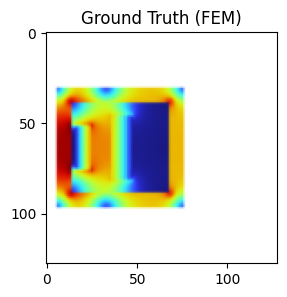

In [33]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.imshow(baseline_image_PIL)
ax.set_xticks(tick_locations)
ax.set_yticks(tick_locations)
ax.set_title('Ground Truth (FEM)')

plt.savefig('ground_truth.eps')